In [2]:
%cd "/Users/rajakumar/Desktop/MS/Fall-2022/research/2D_Landmarks/DAD-3DHeads"

/Users/rajakumar/Desktop/MS/Fall-2022/research/2D_Landmarks/DAD-3DHeads


In [3]:
import os

### checking the sensitivity with crop

In [1]:
# error function
import numpy as np
def calculate_error(x,y, pred_x, pred_y):
    norm_factor = (np.sqrt(np.square(x[36]-x[45]) + np.square(y[36]-y[47])))*len(x)
    ret = 0
    for i in range(len(x)):
        ret += np.sqrt(np.square(pred_x[i]-x[i]) + np.square(pred_y[i]-y[i]))
    return ret/norm_factor

In [4]:
from functools import partial
from collections import namedtuple
import os
from fire import Fire
from pytorch_toolbelt.utils import read_rgb_image
from predictor import FaceMeshPredictor

image_path = "../Dataset/H3DS_sample/sample2/original/0/img_0009.jpg"
def run_dad_net(image_path):
    image = read_rgb_image(image_path)
    predictor = FaceMeshPredictor.dad_3dnet()
    predictions = predictor(image)
    print(type(predictions))
    coordinates = predictions['points']
    x_pred,y_pred = coordinates[:,0], coordinates[:,1]
    return x_pred, y_pred
#print(x_pred, y_pred)

/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd

annotation_file = "../Dataset/H3DS_sample/sample2/Annotations_cropped_1024/img_0009.csv"
df = pd.read_csv(annotation_file)
df1 = df["region_shape_attributes"]

x_gt = []
y_gt = []

for point in df1:
    x_gt.append(int(point[21:24]))
    y_gt.append(int(point[30:33]))

## for 2048 resolution
def find_cropped_cordinates(new_h, new_w):
    if (new_h >= 1024):
        new_x = np.array(x_gt) + (new_h-1024)/2
        new_y = np.array(y_gt) + (new_w-1024)/2
    else:
        new_x = np.array(x_gt) - (1024-new_h)/2
        new_y = np.array(y_gt) - (1024-new_w)/2

    return new_x,new_y

In [44]:
#
#find_cropped_cordinates(2048,2048,1024,1024)

In [9]:
import matplotlib.pyplot as plt
from skimage import io

'''input = io.imread(image_path)
plt.imshow(input)
plt.plot(x_pred, y_pred,"og", markersize=2)
plt.plot(x,y,"or", markersize=2)'''

'input = io.imread(image_path)\nplt.imshow(input)\nplt.plot(x_pred, y_pred,"og", markersize=2)\nplt.plot(x,y,"or", markersize=2)'

In [29]:
#error(x,y,x_pred,y_pred)

In [6]:
import cv2
def sensitivity_to_crop(original_image):
    img = cv2.imread(original_image)
    center = img.shape
    h_orig, w_orig = center[0], center[1]
    i = 1
    error = []
    landmarks = {}
    gt_lmks = {}

    while(i <= 3.0):
        h,w = int(h_orig/i), int(w_orig/i)
        x = center[1]/2 - w/2
        y = center[0]/2 - h/2
        crop_img = img[int(y):int(y+h), int(x):int(x+w)]
        filename = os.path.splitext(os.path.basename(image_path))[0] + str(h) + "_" + str(w) + ".jpg"
        output_path = os.path.join("./experiments/crop_sensitivity/", filename)
        cv2.imwrite(output_path, crop_img)

        x_pred, y_pred = run_dad_net(output_path)
        x,y = find_cropped_cordinates(h,w)

        curr_error = calculate_error(x,y,x_pred,y_pred)
        error.append(curr_error)
        landmarks[filename] = [x_pred,y_pred]
        gt_lmks[filename] = [x,y]

        i += 0.1
    
    return error,landmarks, gt_lmks
        

In [7]:
error, lmks, gt_lmks = sensitivity_to_crop(image_path)

/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


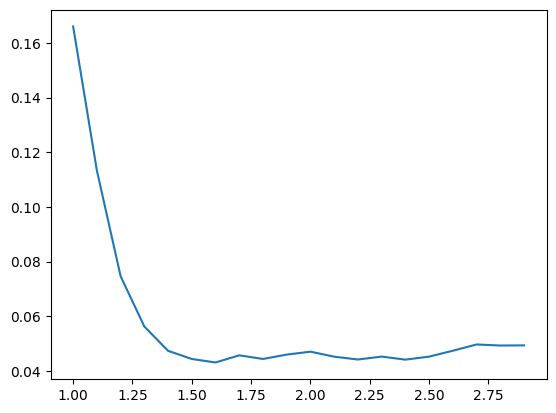

In [10]:
x_axis = []
j = 1
while(j <= 3.0):
    x_axis.append(j)
    j += 0.1
plt.plot(x_axis, error)

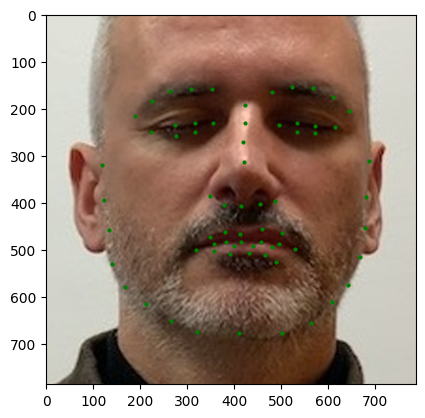

In [101]:
from skimage import io
image_1280 = "./experiments/crop_sensitivity/img_0009787_787.jpg"
best_input = io.imread(image_1280)
plt.imshow(best_input)
lmks_x,lmks_y = gt_lmks["img_0009787_787.jpg"][0], gt_lmks["img_0009787_787.jpg"][1]
plt.plot(lmks_x,lmks_y,"og", markersize=2)

#### earlier testing codes

In [66]:
! python demo.py "./experiments/crop_sensitivity/img_00091280_1280.jpg" outputs 68_landmarks

/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)
<class 'dict'>
[[352 551]
 [365 61

In [17]:
data_path = "../Dataset/facescape_sample/sample-1/"
files = os.listdir(data_path)
output_path = "outputs/facescape_sample/"
for file in files:
    curr_image = os.path.join(data_path, file)
    print(curr_image)
    command = "python demo.py " + curr_image +  " " + output_path + "191_landmarks" + " " + "191_landmarks"
    print(command)
    os.system(command)
    break

../Dataset/facescape_sample/sample-1/28.jpg
python demo.py ../Dataset/facescape_sample/sample-1/28.jpg outputs/facescape_sample/191_landmarks 191_landmarks


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


In [11]:
data_path = "../Dataset/H3DS_sample/sample1/"
files = os.listdir(data_path)
output_path = "outputs/H3DS/"
for file in files:
    curr_image = os.path.join(data_path, file)
    print(curr_image)
    command = "python demo.py " + curr_image +  " " + output_path + "68_landmarks"
    os.system(command)

../Dataset/H3DS_sample/sample1/img_0000.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


../Dataset/H3DS_sample/sample1/img_0003.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


../Dataset/H3DS_sample/sample1/img_0060.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


../Dataset/H3DS_sample/sample1/img_0066.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


../Dataset/H3DS_sample/sample1/img_0051.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


../Dataset/H3DS_sample/sample1/img_0046.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


In [2]:
data_path = "../Dataset/DAD-3DHeadsDataset/sample_test/"
files = os.listdir(data_path)
output_path = "outputs/DAD-3D/"
for file in files:
    curr_image = os.path.join(data_path, file)
    print(curr_image)
    command = "python demo.py " + curr_image +  " " + output_path + "68_landmarks" + " 68_landmarks"
    os.system(command)

../Dataset/DAD-3DHeadsDataset/sample_test/0c025010-eead-4e5b-a7bc-38ace77b25f8.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0e956fae-2468-42c9-8bf7-d070f7f7934b.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0e562bd4-ba2b-43f4-92b4-5d2909ad6670.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/1c3bec3d-e8cf-42df-9cda-28c04c828b51.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0af5cca5-6bb0-4d37-9ae2-ad63e5e3099c.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0fda8062-2cdb-4a4f-aecf-26bd5a74a315.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0d98ad7f-6bd0-4e19-9918-6570b3702820.png


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/DAD-3DHeadsDataset/sample_test/0b502a02-9964-4ffe-8cf2-76940572b53e.png
<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


#### check after decreasing resolutions

In [12]:
from ast import Or
import os
import cv2

original_image_path = "../Dataset/H3DS_sample/sample2/cropped_1024/"
output_image_path = "../Dataset/H3DS_sample/sample2/cropped_1024_ds_256/"

images = os.listdir(original_image_path)

for image in images:
    curr_image = os.path.join(original_image_path, image)
    img = cv2.imread(curr_image)
    img = cv2.resize(img, (256,256))
    output_image = os.path.join(output_image_path, image)
    cv2.imwrite(output_image, img)

In [6]:
"""cv2.imshow("lower_reolution", lower_resolution)
cv2.waitKey(0)
cv2.destroyAllWindows()"""

In [17]:
def run_DAD_directory(data_path, output_path):
    files = os.listdir(data_path)
    for file in files:
        curr_image = os.path.join(data_path, file)
        print(curr_image)
        command = "python demo.py " + curr_image +  " " + output_path + "68_landmarks" + " 68_landmarks"
        os.system(command)

In [11]:
data_path = "../Dataset/H3DS_sample/sample2/original/"
output_path = "outputs/H3DS/sample2/original/"
data_path2 = "../Dataset/H3DS_sample/sample2/lower_resolution/"
output_path2 = "outputs/H3DS/sample2/lower_resolution/"

run_DAD_directory(data_path, output_path)
run_DAD_directory(data_path2, output_path2)

../Dataset/H3DS_sample/sample2/original/img_0014.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0015.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0012.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0013.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0007.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0010.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0065.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0066.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0009.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/original/img_0008.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0014.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0015.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0012.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0013.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0007.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0010.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0065.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0066.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0009.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/lower_resolution/img_0008.jpg
<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


In [13]:
data_path3 = "../Dataset/H3DS_sample/sample2/512/"
output_path3 = "outputs/H3DS/sample2/512/"

run_DAD_directory(data_path3, output_path3)

../Dataset/H3DS_sample/sample2/512/img_0014.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0015.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0012.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0013.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0007.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0010.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0065.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0066.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0009.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample2/512/img_0008.jpg
<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


### try after croping

In [13]:
import cv2
img = cv2.imread("../Dataset/H3DS_sample/sample2/original/img_0007.jpg")
center = img.shape
w,h = 1024,1024
x = center[1]/2 - w/2
y = center[0]/2 - h/2
crop_img = img[int(y):int(y+h), int(x):int(x+w)]
print(crop_img.shape)
"""cv2.imshow("cropped", crop_img)
cv2.waitKey(0)"""
cv2.imwrite("../Dataset/H3DS_sample/img_test.jpg", crop_img)

(1024, 1024, 3)


True

In [24]:
from ast import Or
import os
import cv2

original_image_path = "../Dataset/H3DS_sample/sample1/original/"
output_image_path = "../Dataset/H3DS_sample/sample1/cropped_1024"

images = os.listdir(original_image_path)

for image in images:
    curr_image = os.path.join(original_image_path, image)
    img = cv2.imread(curr_image)
    center = img.shape
    w,h = 1024,1024
    x = center[1]/2 - w/2
    y = center[0]/2 - h/2
    crop_img = img[int(y):int(y+h), int(x):int(x+w)]
    output_image = os.path.join(output_image_path, image)
    print(output_image)
    print(crop_img.shape)
    cv2.imwrite(output_image, crop_img)

../Dataset/H3DS_sample/sample1/cropped_1024/img_0000.jpg
(1024, 1024, 3)
../Dataset/H3DS_sample/sample1/cropped_1024/img_0003.jpg
(1024, 1024, 3)
../Dataset/H3DS_sample/sample1/cropped_1024/img_0060.jpg
(1024, 1024, 3)
../Dataset/H3DS_sample/sample1/cropped_1024/img_0066.jpg
(1024, 1024, 3)
../Dataset/H3DS_sample/sample1/cropped_1024/img_0051.jpg
(1024, 1024, 3)
../Dataset/H3DS_sample/sample1/cropped_1024/img_0046.jpg
(1024, 1024, 3)


In [25]:
data_path4 = "../Dataset/H3DS_sample/sample1/cropped_1024/"
output_path4 = "outputs/H3DS/sample1/cropped_1024/"

run_DAD_directory(data_path4, output_path4)

../Dataset/H3DS_sample/sample1/cropped_1024/img_0000.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample1/cropped_1024/img_0003.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample1/cropped_1024/img_0060.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample1/cropped_1024/img_0066.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample1/cropped_1024/img_0051.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/H3DS_sample/sample1/cropped_1024/img_0046.jpg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])


In [22]:
data_path4 = "../Dataset/raja/sample1/"
output_path4 = "outputs/raja/"

run_DAD_directory(data_path4, output_path4)

../Dataset/raja/sample1/IMG_0776.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/IMG_0782.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/.DS_Store


Traceback (most recent call last):
  File "demo.py", line 61, in <module>
    Fire(demo)
  File "/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/fire/core.py", line 141, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/fire/core.py", line 466, in _Fire
    component, remaining_args = _CallAndUpdateTrace(
  File "/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/fire/core.py", line 681, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "demo.py", line 47, in demo
    image = read_rgb_image(input_image_path)
  File "/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/pytorch_toolbelt/utils/fs.py", line 112, in read_rgb_image
    raise IOError(f'Cannot read image "{fname}"')
OSError: Cannot read image "../Dataset/raja/sample1/.DS_Store"


../Dataset/raja/sample1/IMG_0777.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/IMG_0774.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/IMG_0778.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/IMG_0779.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
../Dataset/raja/sample1/IMG_0775.jpeg


/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
/Users/rajakumar/miniforge3/envs/dad_3d/lib/python3.8/site-packages/torch/nn/modules/module.py:1051: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return forward_call(*input, **kwargs)


<class 'dict'>
dict_keys(['points', 'projected_vertices', '3d_vertices', '3dmm_params'])
